# **Data**

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.utils import pad_sequences,plot_model
from sklearn import model_selection
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow import keras
from string import printable
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Model,load_model
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, ELU, LSTM, Embedding, BatchNormalization, Conv1D, MaxPooling1D,GRU,SimpleRNN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from scipy.io.arff import loadarff 
%matplotlib inline

In [2]:
import tensorboard
from datetime import datetime
from packaging import version

In [3]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [5]:
df=pd.read_csv('phishing_site_urls.csv')

In [6]:
df.shape

(549346, 2)

In [7]:
df['URL'][1]

'www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php'

In [8]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

In [9]:
df['Label'].value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

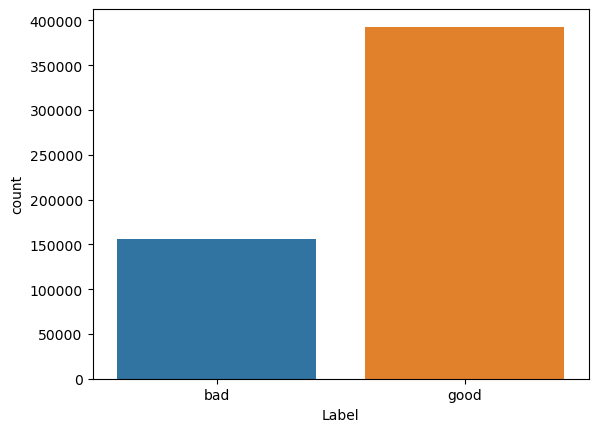

In [10]:
sns.countplot(x='Label', data=df)

In [11]:
df.loc[df["Label"] == 'bad', "Label"] = 0
df.loc[df["Label"] == "good", "Label"] = 1
df.Label.value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

In [12]:
class_1_indices = np.where(df.Label == 1)[0][:156422]
class_0_indices = np.where(df.Label == 0)[0]

In [13]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0


# example preprocessing

In [14]:
character_encoding=[printable.index(x) + 1 for x in printable]
for x in range(0,len(character_encoding)):
  print(printable[x],"=",character_encoding[x],"\n")

0 = 1 

1 = 2 

2 = 3 

3 = 4 

4 = 5 

5 = 6 

6 = 7 

7 = 8 

8 = 9 

9 = 10 

a = 11 

b = 12 

c = 13 

d = 14 

e = 15 

f = 16 

g = 17 

h = 18 

i = 19 

j = 20 

k = 21 

l = 22 

m = 23 

n = 24 

o = 25 

p = 26 

q = 27 

r = 28 

s = 29 

t = 30 

u = 31 

v = 32 

w = 33 

x = 34 

y = 35 

z = 36 

A = 37 

B = 38 

C = 39 

D = 40 

E = 41 

F = 42 

G = 43 

H = 44 

I = 45 

J = 46 

K = 47 

L = 48 

M = 49 

N = 50 

O = 51 

P = 52 

Q = 53 

R = 54 

S = 55 

T = 56 

U = 57 

V = 58 

W = 59 

X = 60 

Y = 61 

Z = 62 

! = 63 

" = 64 

# = 65 

$ = 66 

% = 67 

& = 68 

' = 69 

( = 70 

) = 71 

* = 72 

+ = 73 

, = 74 

- = 75 

. = 76 

/ = 77 

: = 78 

; = 79 

< = 80 

= = 81 

> = 82 

? = 83 

@ = 84 

[ = 85 

\ = 86 

] = 87 

^ = 88 

_ = 89 

` = 90 

{ = 91 

| = 92 

} = 93 

~ = 94 

  = 95 

	 = 96 


 = 97 

 = 98 

 = 99 

 = 100 



In [15]:
url='https://www.apple.com/'
encoded=[printable.index(x) + 1 for x in url if x in printable]
print(encoded)

[18, 30, 30, 26, 29, 78, 77, 77, 33, 33, 33, 76, 11, 26, 26, 22, 15, 76, 13, 25, 23, 77]


# **Pre-processing**

In [16]:
#1) encoding the characters in URL from 1 to 100, using nested list comprehension.
url_encoded = [[printable.index(x) + 1 for x in url if x in printable] for url in df.URL]

In [17]:
#2)Length normalization, The length of all URL's normalized at fixed length, if the (url length< fixed length) zeroes are added at front of the url,
# if the (url length> fixed length) the etra character are intercepted from the end
max_len=75
X = pad_sequences(url_encoded, maxlen=max_len, truncating='post')

In [18]:
X = np.concatenate((X[class_1_indices], X[class_0_indices[:156422]]))

In [19]:
X.shape

(312844, 75)

In [20]:
y = np.array(df.Label)

In [21]:
y = np.concatenate((y[class_1_indices], y[class_0_indices[:156422]]))

In [22]:
y.shape

(312844,)

# **Splitting-data**

In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=33)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [26]:
model = keras.Sequential([
    layers.Input(shape=X_train.shape[1]),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9728      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
X_train = np.asarray(X_train).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [31]:
epochs = 50
batch_size = 32

his1=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/50
7822/7822 [==============================] - 84s 10ms/step - loss: 0.7631 - accuracy: 0.6600 - val_loss: 0.5724 - val_accuracy: 0.7405
Epoch 2/50
7822/7822 [==============================] - 79s 10ms/step - loss: 0.6064 - accuracy: 0.7186 - val_loss: 0.5458 - val_accuracy: 0.7547
Epoch 3/50
7822/7822 [==============================] - 77s 10ms/step - loss: 0.5988 - accuracy: 0.7256 - val_loss: 0.5383 - val_accuracy: 0.7581
Epoch 4/50
7822/7822 [==============================] - 73s 9ms/step - loss: 0.5956 - accuracy: 0.7284 - val_loss: 0.5389 - val_accuracy: 0.7578
Epoch 5/50
7822/7822 [==============================] - 3935s 503ms/step - loss: 0.5940 - accuracy: 0.7295 - val_loss: 0.5367 - val_accuracy: 0.7606
Epoch 6/50
7822/7822 [==============================] - 42s 5ms/step - loss: 0.5908 - accuracy: 0.7305 - val_loss: 0.5344 - val_accuracy: 0.7667
Epoch 7/50
7822/7822 [==============================] - 52s 7ms/step - loss: 0.5889 - accuracy: 0.7332 - val_loss: 0.5282 -

KeyboardInterrupt: 

In [ ]:
epochs = 50
batch_size = 32

his1=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/50
7822/7822 [==============================] - 49s 6ms/step - loss: 0.4382 - accuracy: 0.8017 - val_loss: 0.3867 - val_accuracy: 0.8281
Epoch 2/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4373 - accuracy: 0.8017 - val_loss: 0.3877 - val_accuracy: 0.8269
Epoch 3/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4374 - accuracy: 0.8031 - val_loss: 0.3854 - val_accuracy: 0.8291
Epoch 4/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4381 - accuracy: 0.8016 - val_loss: 0.3847 - val_accuracy: 0.8277
Epoch 5/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4368 - accuracy: 0.8036 - val_loss: 0.3852 - val_accuracy: 0.8308
Epoch 6/50
7822/7822 [==============================] - 47s 6ms/step - loss: 0.4372 - accuracy: 0.8023 - val_loss: 0.3851 - val_accuracy: 0.8308
Epoch 7/50
7822/7822 [==============================] - 47s 6ms/step - loss: 0.4373 - accuracy: 0.8032 - val_loss: 0.3876 - val_ac

In [ ]:
epochs = 50
batch_size = 32

his1=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/50
7822/7822 [==============================] - 49s 6ms/step - loss: 0.4382 - accuracy: 0.8017 - val_loss: 0.3867 - val_accuracy: 0.8281
Epoch 2/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4373 - accuracy: 0.8017 - val_loss: 0.3877 - val_accuracy: 0.8269
Epoch 3/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4374 - accuracy: 0.8031 - val_loss: 0.3854 - val_accuracy: 0.8291
Epoch 4/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4381 - accuracy: 0.8016 - val_loss: 0.3847 - val_accuracy: 0.8277
Epoch 5/50
1788/7822 [=====>........................] - ETA: 36s - loss: 0.4310 - accuracy: 0.8058

In [ ]:
epochs = 50
batch_size = 32

his1=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/50
7822/7822 [==============================] - 49s 6ms/step - loss: 0.4382 - accuracy: 0.8017 - val_loss: 0.3867 - val_accuracy: 0.8281
Epoch 2/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4373 - accuracy: 0.8017 - val_loss: 0.3877 - val_accuracy: 0.8269
Epoch 3/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4374 - accuracy: 0.8031 - val_loss: 0.3854 - val_accuracy: 0.8291
Epoch 4/50
7822/7822 [==============================] - 48s 6ms/step - loss: 0.4381 - accuracy: 0.8016 - val_loss: 0.3847 - val_accuracy: 0.8277
Epoch 5/50
1788/7822 [=====>........................] - ETA: 36s - loss: 0.4310 - accuracy: 0.8058

In [52]:
model.save('Mini_Proj.keras')

In [53]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print('\nValidation Accuracy', test_accuracy, '\n')

1717/1717 [==============================] - 7s 4ms/step - loss: 0.2960 - accuracy: 0.8829

Validation Accuracy 0.8828797936439514 



In [36]:
predictions=model.predict(X_test)

978/978 [==============================] - 3s 3ms/step


In [37]:
predictions = (predictions>=0.5).astype(int)

In [56]:
predictions.shape

(54935, 1)

In [38]:
cm=confusion_matrix(y_test,predictions)
cm

array([[13316,  2471],
       [ 2068, 13429]], dtype=int64)

In [58]:
predictions.shape

(54935, 1)

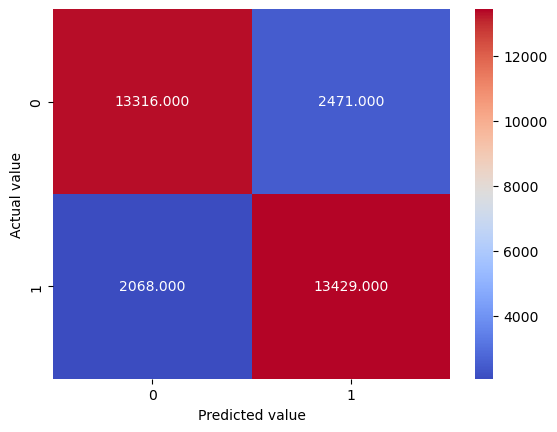

In [39]:
sns.heatmap(cm, annot=True, cmap='coolwarm',fmt='0.3f')
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

In [60]:
accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
accuracy

0.8828797669973605

In [40]:
accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
accuracy

0.854909858074415

In [61]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78     15659
         1.0       0.90      0.94      0.92     39276

    accuracy                           0.88     54935
   macro avg       0.87      0.84      0.85     54935
weighted avg       0.88      0.88      0.88     54935



In [42]:
h1=his1.history
h1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

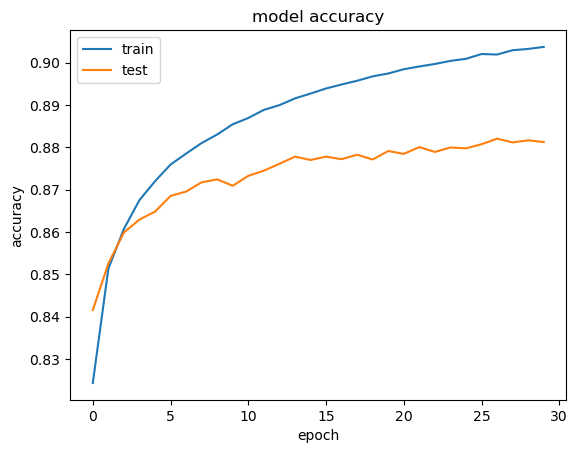

In [63]:
# summarize history for accuracy
plt.plot(h1['accuracy'])
plt.plot(h1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

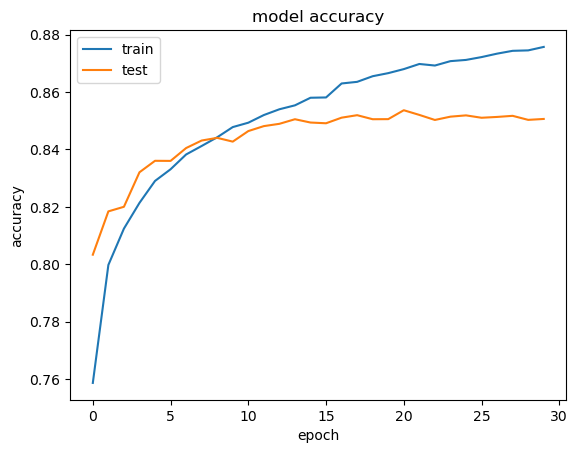

In [43]:
# summarize history for accuracy
plt.plot(h1['accuracy'])
plt.plot(h1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

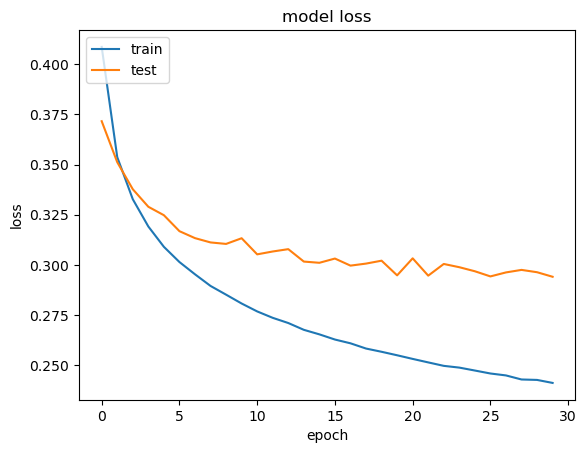

In [64]:
# summarize history for loss
plt.plot(h1['loss'])
plt.plot(h1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ***TESTING***

In [113]:
def output_gru(url):
  gru_model=load_model("Mini_Proj.keras")
  encoded_url=[[printable.index(x) + 1 for x in url if x in printable]]
  max_len=75
  preprocessed_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
  return np.argmax(gru_model.predict(preprocessed_url,batch_size=1)),gru_model.predict(preprocessed_url,batch_size=1)

In [114]:
# Took a random website link from Phishtank which has all phishing links
output_gru('enterspages.com/QC/St-Leonard-apartment.html')

1/1 [==============================] - 0s 21ms/step


(0, array([[1.]], dtype=float32))

In [89]:
cnn_gru_model=load_model("Mini_Proj.keras")

In [90]:
cnn_gru_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               9728      
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 16)                528       
                                                                 
 dense_48 (Dense)            (None, 8)                 136       
                                                                 
 dense_49 (Dense)            (None, 4)                 36        
                                                                 
 dense_50 (Dense)            (None, 1)                

In [91]:
cnn_gru_model.evaluate(X_train,y_train,verbose=1)

13734/13734 [==============================] - 47s 3ms/step - loss: 0.2331 - accuracy: 0.9085


[0.23314547538757324, 0.9085205793380737]

In [92]:
test_url='https:\\www.google.com'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 143ms/step


array([[1.]], dtype=float32)

In [96]:
test_url='website.com/paypal.com/enterspages.com/QC/St-Leonard-apartment.html'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 40ms/step


array([[1.]], dtype=float32)